In [55]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import itertools
import numpy as np


def load_dfs( MAX_DATE = None , MIN_DATE = None):
    nba_teams = ['MIL', 'CHI', 'CHA', 'TOR', 'BOS', 'PHX', 'OKC', 'LAC', 'IND',
           'BKN', 'MIN', 'UTA', 'SAS', 'DAL', 'CLE', 'NYK', 'POR', 'HOU',
           'DEN', 'MEM', 'SAC', 'PHI',  'ATL', 'LAL', 
           'WAS', 'ORL', 'GSW', 'NOP', 
           'MIA', 
           'DET']
    nba_team_ids =[1610612749, 1610612766, 1610612738, 1610612746, 1610612754,
           1610612750, 1610612741, 1610612742, 1610612762, 1610612759,
           1610612739, 1610612752, 1610612761, 1610612760, 1610612757,
           1610612751, 1610612745, 1610612756, 1610612743, 1610612755,
           1610612737, 1610612763, 1610612764, 1610612744, 1610612740,
           1610612753, 1610612747, 1610612758, 1610612748, 1610612765]

   



    nba_teams_df = pd.DataFrame(nba_teams)
    dummy_nba_teams= pd.get_dummies(nba_team_ids, prefix ='team')


    df = pd.read_csv('large_boxscoretraditionalv2_df.csv')
    df=df[df['TEAM_ID'].isin(nba_team_ids)]
    df.drop_duplicates(subset = ['GAME_ID','PLAYER_ID'],inplace=True)
    df.dropna(subset=['MIN'],inplace=True)



    df_g = pd.read_csv('all_games.csv')
    df_g.drop_duplicates(subset =['TEAM_ID','GAME_ID'],inplace=True)

    df_g.loc[df_g['WL']=='W','IsWin']=1
    df_g.loc[df_g['WL']=='L','IsWin']=0
    df_g['IsHome'] = (df_g['MATCHUP'].str.contains('vs.')).astype(int)
    df_g['Opposing_team'] = df_g['MATCHUP'].apply( lambda x: x.split(' ')[2])

    df_g=df_g[df_g['TEAM_ID'].isin(nba_team_ids)]
    team_abv_to_id_mapping = df_g[['TEAM_ABBREVIATION','TEAM_ID']].drop_duplicates().set_index('TEAM_ABBREVIATION')['TEAM_ID'].to_dict()
    df_g['Opposing_team_ID'] = df_g['Opposing_team'].apply(lambda x: team_abv_to_id_mapping[x] if x in team_abv_to_id_mapping else None )

    df_g=df_g[df_g['Opposing_team_ID'].isin(nba_team_ids)]

    # df_g=df_g[['GAME_ID','TEAM_ID','GAME_DATE']].drop_duplicates().dropna()
    df_g['GAME_DATE'] = pd.to_datetime(df_g['GAME_DATE'])
    
    if MAX_DATE is not None:
        df_g = df_g[df_g['GAME_DATE']<MAX_DATE]
    if MIN_DATE is not None:
        df_g = df_g[df_g['GAME_DATE']>MIN_DATE]
    # add balance scoring


    df = df.merge(df_g, 
         how='inner',
         left_on=['GAME_ID','TEAM_ID'],
         right_on=['GAME_ID','TEAM_ID'])


    pbp = pd.read_csv('large_playbyplayv2_df.csv', index_col=0)
    pbp.drop_duplicates(subset=['GAME_ID','EVENTNUM','PERIOD'], inplace=True)


    shot_chart_df =  pd.read_csv('ShotChartDetail_v2.csv')
    shot_chart_df.drop_duplicates(subset=['GAME_ID','GAME_EVENT_ID'], inplace=True)
    
    df_g['num_of_possessions'] = df_g.apply( lambda x: get_possessions_per_game_and_team(x,pbp), axis=1)
    df_g.dropna(subset=['num_of_possessions'],inplace=True)
    df_g['AdjustedPM'] = (df_g['PLUS_MINUS']/df_g['num_of_possessions'])*100
    df_g['OffRating'] = (df_g['PTS']/df_g['num_of_possessions'])*100
    df_g['EFG'] = (df_g['FGM'] + 0.5*df_g['FG3M'])/df_g['FGA']
    df_g['AST_ratio'] = df_g['AST']*100/((df_g['FGA'])+(df_g['FTA']*0.44)+(df_g['AST'])+(df_g['AST']))
    df_g['Opp_points'] = df_g['PTS'] + df_g['PLUS_MINUS']
    df_g['Def_Rating'] = (df_g['Opp_points'] / df_g['num_of_possessions'])*100

    ['AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']



    print('done')
    return df,df_g,pbp,shot_chart_df,team_abv_to_id_mapping

df,df_g,pbp,shot_chart_df,team_abv_to_id_mapping = load_dfs(  MAX_DATE = '2020-01-01',MIN_DATE = '2018-11-01')

done


In [ ]:
### Check how much is left

# df = pd.read_csv('large_boxscoretraditionalv2_df.csv')
# df=df[df['TEAM_ID'].isin(nba_team_ids)]
# df.drop_duplicates(subset = ['GAME_ID','PLAYER_ID'],inplace=True)
# df.dropna(subset=['MIN'],inplace=True)

# df_g[(~df_g['GAME_ID'].isin(df['GAME_ID']))&
#     (df_g['TEAM_ID'].isin(nba_team_ids))].groupby('GAME_DATE').size()

In [2]:

def get_possessions_per_game_and_team(row,pbp):
    try:
        GAME_ID = row['GAME_ID']
        is_home = row['IsHome']
        single_game = pbp[pbp['GAME_ID']==GAME_ID]
        index_indicator = 'Home_EOP' if is_home==1 else 'Visitor_EOP'

        single_game = single_game.sort_values('EVENTNUM')
        single_game['Shift_HOMEDESCRIPTION'] = single_game['HOMEDESCRIPTION'].shift(-1)
        single_game[['Shift_HOMEDESCRIPTION','HOMEDESCRIPTION']]
        single_game.loc[(single_game['HOMEDESCRIPTION'].isnull()==False)&
                        (single_game['Shift_HOMEDESCRIPTION'].isnull()==True)&
                        (single_game['EVENTMSGTYPE'].isin([1,2,3,4,5,7,9])),'Home_EOP'] = 1
        single_game['Home_EOP'].fillna(0,inplace=True)
        single_game[['Shift_HOMEDESCRIPTION','HOMEDESCRIPTION','VISITORDESCRIPTION','Home_EOP']]

        single_game['Shift_VISITORDESCRIPTION'] = single_game['VISITORDESCRIPTION'].shift(-1)
        single_game[['Shift_VISITORDESCRIPTION','VISITORDESCRIPTION']]
        single_game.loc[(single_game['VISITORDESCRIPTION'].isnull()==False)&
                        (single_game['Shift_VISITORDESCRIPTION'].isnull()==True)&
                        (single_game['EVENTMSGTYPE'].isin([1,2,3,4,5,7,9])),'Visitor_EOP'] = 1
        single_game['Visitor_EOP'].fillna(0,inplace=True)
        return single_game[['Home_EOP','Visitor_EOP']].sum().loc[index_indicator]
    except:
        return np.nan




In [56]:
nba_teams = ['MIL', 'CHI', 'CHA', 'TOR', 'BOS', 'PHX', 'OKC', 'LAC', 'IND',
       'BKN', 'MIN', 'UTA', 'SAS', 'DAL', 'CLE', 'NYK', 'POR', 'HOU',
       'DEN', 'MEM', 'SAC', 'PHI',  'ATL', 'LAL', 
       'WAS', 'ORL', 'GSW', 'NOP', 
       'MIA', 
       'DET']
nba_team_ids =[1610612749, 1610612766, 1610612738, 1610612746, 1610612754,
       1610612750, 1610612741, 1610612742, 1610612762, 1610612759,
       1610612739, 1610612752, 1610612761, 1610612760, 1610612757,
       1610612751, 1610612745, 1610612756, 1610612743, 1610612755,
       1610612737, 1610612763, 1610612764, 1610612744, 1610612740,
       1610612753, 1610612747, 1610612758, 1610612748, 1610612765]





nba_teams_df = pd.DataFrame(nba_teams)
dummy_nba_teams= pd.get_dummies(nba_team_ids, prefix ='team')

sliding_window_num_of_games = 3

large_df_of_sequences = pd.DataFrame([])
 
# create the sliding window dataframe per team
for team in nba_team_ids:
    print(team)
    x = df_g[df_g['TEAM_ID'] == team].sort_values('GAME_DATE').reset_index(drop=True)
    
    
    dummy_curr_team = pd.get_dummies(x['TEAM_ID'], prefix ='team').reindex(columns = dummy_nba_teams.columns, fill_value=0)
    dummy_curr_team.columns = ['curr_' + col for col in dummy_curr_team.columns]
    team_indicator = dummy_curr_team.loc[0].values
    
    
    list_team_indicator = list(team_indicator) 
    for ix,row in x[sliding_window_num_of_games:].iterrows():
        tmp = x.loc[ix-sliding_window_num_of_games:ix]
        
        # add sequence of wins
        list_of_sequence_of_wins = list(tmp['IsWin'].values)
        new_cols = []
        for game in range(sliding_window_num_of_games):
                new_cols.insert(0,'{}_games_back_IsWin'.format(game + 1))
        new_cols.append('Y') 
        df_of_sequence_of_wins = pd.DataFrame([list_of_sequence_of_wins],columns=new_cols)
        
        # get team indicator
        team_indicator = dummy_curr_team[0:1]
        
        # is at home
        list_of_sequence_of_at_home = list(tmp['IsHome'].values)
        new_cols = []
        for game in range(sliding_window_num_of_games+1):
                new_cols.insert(0,'{}_games_back_IsHome'.format(game + 1))
        df_of_sequence_of_at_home = pd.DataFrame([list_of_sequence_of_at_home],columns=new_cols)
        
        # get opp team indicator 
        opp_dummy_teams = pd.get_dummies(tmp['Opposing_team_ID'].astype(int), prefix ='team').reindex(columns = dummy_nba_teams.columns, fill_value=0)
        opp_dummy_teams.columns = ['opp_' + col for col in opp_dummy_teams.columns]
        appended_list_of_encoded_opp_teams = list(itertools.chain(*opp_dummy_teams.values))
        appended_df_of_encoded_opp_teams = pd.DataFrame([appended_list_of_encoded_opp_teams])
        
        # add averages of categories
        cols_to_calc = ['PTS','REB','AST','STL','BLK','TOV','PLUS_MINUS','FG3_PCT','FG_PCT','FT_PCT','num_of_possessions',
                       'AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']
        averages_of_categories_curr_team = tmp[cols_to_calc][:-1].mean().values
        df_of_averages_of_categories_curr_team = pd.DataFrame([averages_of_categories_curr_team],columns =cols_to_calc)
        
        
        # add shot area avgs for curr team
        shot_index= ['Mid-Range', 'In The Paint (Non-RA)', 'Restricted Area',
       'Above the Break 3', 'Left Corner 3', 'Right Corner 3']

        shot_chart_df_for_tmp = shot_chart_df[(shot_chart_df['GAME_ID'].isin(tmp[:-1]['GAME_ID'].values))&
                                 (shot_chart_df['TEAM_ID']==team)].groupby(
                                    ['SHOT_ZONE_BASIC']).mean()['SHOT_MADE_FLAG'].reset_index()
        shot_chart_df_for_tmp_reindex = shot_chart_df_for_tmp[['SHOT_ZONE_BASIC','SHOT_MADE_FLAG']].set_index('SHOT_ZONE_BASIC').reindex(shot_index).fillna(0)
        shot_area_avgs = shot_chart_df_for_tmp_reindex.T.reset_index(drop=True)
        
        # add shot chart of opposing teams during window
        shot_chart_df_for_tmp = shot_chart_df[(shot_chart_df['GAME_ID'].isin(tmp[:-1]['GAME_ID'].values))&
                                 (shot_chart_df['TEAM_ID']!=team)].groupby(
                                    ['SHOT_ZONE_BASIC']).mean()['SHOT_MADE_FLAG'].reset_index()
        shot_chart_df_for_tmp_reindex = shot_chart_df_for_tmp[['SHOT_ZONE_BASIC','SHOT_MADE_FLAG']].set_index('SHOT_ZONE_BASIC').reindex(shot_index).fillna(0)
        shot_area_avgs_opp = shot_chart_df_for_tmp_reindex.T.reset_index(drop=True)
        
         # add averages of categories for past opponents
        list_of_opp_ids = list(tmp['Opposing_team_ID'].unique())

        x_opp = df_g[(df_g['TEAM_ID'].isin(list_of_opp_ids))&
                    (df_g['GAME_DATE'] < tmp['GAME_DATE'].max())&
                    (df_g['GAME_DATE'] >= tmp['GAME_DATE'].min())].sort_values('GAME_DATE').reset_index(drop=True)
        tmp_opp = x_opp[-sliding_window_num_of_games:ix]
        cols_to_calc = ['PTS','REB','AST','STL','BLK','TOV','PLUS_MINUS','FG3_PCT','FG_PCT','FT_PCT','num_of_possessions',
                       'AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']
        averages_of_categories_opp_team = tmp_opp[cols_to_calc].mean().values
        df_of_averages_of_categories_opp_team = pd.DataFrame([averages_of_categories_opp_team],columns = cols_to_calc).reset_index(drop=True)
        
        # add sequence of days between games
        tmp['GAME_DATE'].diff().dt.days.dropna()
        l = tmp['GAME_DATE'].diff().dt.days.dropna().values
        l = [4 if sl >4 else sl for sl in l]
        new_cols = []
        for game in range(sliding_window_num_of_games):
                new_cols.insert(0,'{}_games_back_PTS'.format(game + 1))

        df_days_between = pd.DataFrame([l],columns=new_cols)

        # start merging all together 
        # 1. wins
        # 2. team indicator
        # 3. at home indicator
        # 4. TOV sequence
#         print(len(team_indicator.columns),'team_indicator')
#         print(len(df_of_sequence_of_wins.columns),'df_of_sequence_of_wins')
#         print(len(df_of_sequence_of_at_home.columns),'df_of_sequence_of_at_home')
#         print(len(appended_df_of_encoded_opp_teams.columns),'appended_df_of_encoded_opp_teams')
#         print(len(df_of_averages_of_categories_curr_team.columns),'df_of_averages_of_categories_curr_team')
#         print(len(shot_area_avgs.columns),'shot_area_avgs')
#         print(len(shot_area_avgs_opp.columns),'shot_area_avgs_opp')
        
        df_all_features = team_indicator.merge(df_of_sequence_of_wins , how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_of_sequence_of_at_home, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(appended_df_of_encoded_opp_teams, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_of_averages_of_categories_curr_team, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(shot_area_avgs, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(shot_area_avgs_opp, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_of_averages_of_categories_opp_team, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_days_between, how='inner' , left_index=True , right_index=True)

        large_df_of_sequences = large_df_of_sequences.append(df_all_features)
    
large_df_of_sequences.dropna(inplace=True)


1610612749
1610612766
1610612738
1610612746
1610612754
1610612750
1610612741
1610612742
1610612762
1610612759
1610612739
1610612752
1610612761
1610612760
1610612757
1610612751
1610612745
1610612756
1610612743
1610612755
1610612737
1610612763
1610612764
1610612744
1610612740
1610612753
1610612747
1610612758
1610612748
1610612765


In [40]:
large_df_of_sequences

,curr_team_1610612737,curr_team_1610612738,curr_team_1610612739,curr_team_1610612740,curr_team_1610612741,curr_team_1610612742,curr_team_1610612743,curr_team_1610612744,curr_team_1610612745,curr_team_1610612746,...,AdjustedPM_y,OffRating_y,EFG_y,AST_ratio_y,Opp_points_y,Def_Rating_y,4_games_back_PTS,3_games_back_PTS,2_games_back_PTS,1_games_back_PTS
0,0,0,0,0,0,0,0,0,0,0,...,-12.745098,90.196078,0.435484,12.239902,79.00,77.450980,2.0,2.0,2.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,-11.504425,78.761062,0.417582,15.967787,76.00,67.256637,2.0,2.0,2.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,9.324934,109.012520,0.512795,16.976874,119.75,118.337453,2.0,2.0,2.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,2.650465,113.249754,0.557011,18.818119,123.00,115.900219,2.0,2.0,2.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,-2.183190,113.622133,0.549481,17.611675,110.75,111.438943,2.0,2.0,2.0,1.0
0,0,0,0,0,0,0,0,0,0,0,...,4.535603,116.033087,0.551226,17.737211,125.50,120.568690,2.0,2.0,1.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,3.579167,104.728992,0.557480,18.654782,111.75,108.308159,2.0,1.0,2.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,6.539424,111.039841,0.541317,18.011436,117.25,117.579266,1.0,2.0,2.0,4.0
0,0,0,0,0,0,0,0,0,0,0,...,5.931458,107.171587,0.546643,15.813219,121.50,113.103045,2.0,2.0,4.0,2.0
0,0,0,0,0,0,0,0,0,0,0,...,-0.874435,121.720380,0.581825,17.703658,121.00,120.845945,2.0,4.0,2.0,2.0


0.6503856041131105
[[238 140]
 [132 268]]
LR: 0.611374 (0.037809)
SVM: 0.604632 (0.015451)


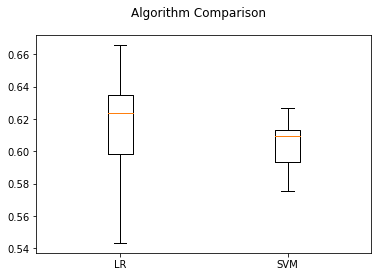

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing



X = large_df_of_sequences.loc[:, large_df_of_sequences.columns != 'Y']
saved_columns = X.columns
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=saved_columns)



Y = large_df_of_sequences['Y']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)


logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

score = logisticRegr.score(x_test, y_test)
print(score)
predictions = logisticRegr.predict(x_test)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)


import matplotlib.pyplot as plt   
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
models = []
models.append(('LR', LogisticRegression()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))


seed = 2

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std() )
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()    

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np 
from sklearn.linear_model import LogisticRegression



X = large_df_of_sequences.loc[:, large_df_of_sequences.columns != 'Y']
saved_columns = X.columns
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=saved_columns)


Y = large_df_of_sequences['Y']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)



pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']}
#     ,
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(50,150,10)),
    'classifier__max_features' : list(range(30,200,10))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(x_train, y_train)
from sklearn.metrics import classification_report
print("Best parameters set found on development set:")
print(best_clf.best_params_)
print("Detailed classification report:")
y_true, y_pred = y_test, best_clf.predict(x_test)
print(classification_report(y_true, y_pred))
print()


Fitting 5 folds for each of 170 candidates, totalling 850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 850 out of 850 | elapsed: 11.2min finished


Best parameters set found on development set:
{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=130, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__max_features': 130, 'classifier__n_estimators': 70}
Detailed classification report:
              precision    recall  f1-score   support

         0.0       0.58      0.62      0.60       378
         1.0       0.62      0.58      0.60       400

    accuracy                           0.60       778
   macro avg       0.60      0.60      0.60       778
weighted avg       0.60      0.60      0.60       778




In [60]:
# lsit_of_games = [
#                 ['BOS','POR'] , 
#                 ['CLE','DET'] , 
#                 ['BKN','OKC'] , 
#                 ['MEM','MIN'] , 
#                 ['PHX','SAC'] , 
#                 ['LAL','NYK'] , 
                
#             ]

# df,df_g,pbp,shot_chart_df,team_abv_to_id_mapping = load_dfs( MAX_DATE = '2020-01-07')
total_results_saved = []

LAST_DATE_TO_RUN_ON = '2020-01-23'
FIRST_DATE_TO_CHECK = '2020-01-01'
df,df_g_global ,pbp,shot_chart_df,team_abv_to_id_mapping = load_dfs( MAX_DATE = LAST_DATE_TO_RUN_ON)

list_of_games_to_check = df_g_global[['GAME_DATE','TEAM_ABBREVIATION','GAME_ID','IsHome']]
len(list_of_games_to_check)
merged_list_of_games_to_check = list_of_games_to_check.merge(list_of_games_to_check,
                                                             how='inner',
                                                             left_on =['GAME_ID'] ,
                                                             right_on =['GAME_ID'])
merged_list_of_games_to_check = merged_list_of_games_to_check[merged_list_of_games_to_check['TEAM_ABBREVIATION_x']!= merged_list_of_games_to_check['TEAM_ABBREVIATION_y']]
merged_list_of_games_to_check=merged_list_of_games_to_check[merged_list_of_games_to_check['IsHome_x']==1]


merged_list_of_games_to_check = merged_list_of_games_to_check[merged_list_of_games_to_check['GAME_DATE_x']>FIRST_DATE_TO_CHECK]
list_of_dates = merged_list_of_games_to_check['GAME_DATE_x'].unique()
for single_date in list_of_dates:
    print (single_date)
    lsit_of_games = []
    for ix,row in merged_list_of_games_to_check[merged_list_of_games_to_check['GAME_DATE_x']==single_date].iterrows():
        game=[row['TEAM_ABBREVIATION_x'],row['TEAM_ABBREVIATION_y']]
        lsit_of_games.append(game)
    df,df_g,pbp,shot_chart_df,team_abv_to_id_mapping = load_dfs( MAX_DATE = str(single_date)[:10])
           
        
        
        
    print(df_g['GAME_DATE'].max())
    for game in lsit_of_games:
    #     print(game)

        df_g['TEAM_ABBREVIATION'].unique()
        ###########################
        ### DEFINE YOUR TEAMS   ###
        ###########################
        curr_team_abv = game[0] #'PHX'
        curr_team_id = team_abv_to_id_mapping[curr_team_abv]

        opp_team = game[1] #'SAC'
        opp_team_id  = team_abv_to_id_mapping[opp_team]
        is_current_game_at_home = 1



        ###########################

        x = df_g[df_g['TEAM_ID'] == curr_team_id].sort_values('GAME_DATE').reset_index(drop=True)
    #     print(tmp)
        tmp = x[-sliding_window_num_of_games:]

        dummy_curr_team = pd.get_dummies(x['TEAM_ID'].astype(int), prefix ='team').reindex(columns = dummy_nba_teams.columns, fill_value=0)
        dummy_curr_team.columns = ['curr_' + col for col in dummy_curr_team.columns]
        team_indicator = dummy_curr_team.loc[0].values

        list_of_sequence_of_wins = list(tmp['IsWin'].values)
        new_cols = []
        for game in range(sliding_window_num_of_games):
                new_cols.insert(0,'{}_games_back_IsWin'.format(game + 1))
        df_of_sequence_of_wins = pd.DataFrame([list_of_sequence_of_wins],columns=new_cols)

        # # get team indicator
        team_indicator = dummy_curr_team[0:1]
        team_indicator

        # is at home
        list_of_sequence_of_at_home = list(tmp['IsHome'].values)
        new_cols = []
        for game in range(sliding_window_num_of_games):
                new_cols.insert(0,'{}_games_back_IsHome'.format(game + 1))
        df_of_sequence_of_at_home = pd.DataFrame([list_of_sequence_of_at_home],columns=new_cols)
        df_of_sequence_of_at_home['{}_games_back_IsHome'.format(sliding_window_num_of_games+1)] = is_current_game_at_home


        # get opp team indicator 

        opp_dummy_teams = pd.get_dummies(tmp['Opposing_team_ID'].astype(int).append(pd.Series(opp_team_id)), prefix ='team').reindex(columns = dummy_nba_teams.columns, fill_value=0)
        opp_dummy_teams.columns = ['opp_' + col for col in opp_dummy_teams.columns]
        appended_list_of_encoded_opp_teams = list(itertools.chain(*opp_dummy_teams.values))
        appended_df_of_encoded_opp_teams = pd.DataFrame([appended_list_of_encoded_opp_teams])

        # add averages of categories
        cols_to_calc = ['PTS','REB','AST','STL','BLK','TOV','PLUS_MINUS','FG3_PCT','FG_PCT','FT_PCT','num_of_possessions',
                           'AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']
        averages_of_categories_curr_team = tmp[cols_to_calc].mean().values
        df_of_averages_of_categories_curr_team = pd.DataFrame([averages_of_categories_curr_team],columns=cols_to_calc)
        df_of_averages_of_categories_curr_team

        # add shot area avgs for curr team
        shot_index= ['Mid-Range', 'In The Paint (Non-RA)', 'Restricted Area',
        'Above the Break 3', 'Left Corner 3', 'Right Corner 3']

        shot_chart_df_for_tmp = shot_chart_df[(shot_chart_df['GAME_ID'].isin(tmp['GAME_ID'].values))&
                                 (shot_chart_df['TEAM_ID']==curr_team_id)].groupby(
                                    ['SHOT_ZONE_BASIC']).mean()['SHOT_MADE_FLAG'].reset_index()
        shot_chart_df_for_tmp_reindex = shot_chart_df_for_tmp[['SHOT_ZONE_BASIC','SHOT_MADE_FLAG']].set_index('SHOT_ZONE_BASIC').reindex(shot_index).fillna(0)
        shot_area_avgs = shot_chart_df_for_tmp_reindex.T.reset_index(drop=True)
        shot_area_avgs

        # add shot chart of opposing teams during window
        shot_chart_df_for_tmp = shot_chart_df[(shot_chart_df['GAME_ID'].isin(tmp[:-1]['GAME_ID'].values))&
                                 (shot_chart_df['TEAM_ID']!=curr_team_id)].groupby(
                                    ['SHOT_ZONE_BASIC']).mean()['SHOT_MADE_FLAG'].reset_index()
        shot_chart_df_for_tmp_reindex = shot_chart_df_for_tmp[['SHOT_ZONE_BASIC','SHOT_MADE_FLAG']].set_index('SHOT_ZONE_BASIC').reindex(shot_index).fillna(0)
        shot_area_avgs_opp = shot_chart_df_for_tmp_reindex.T.reset_index(drop=True)
        shot_area_avgs_opp

          # add averages of categories for past opponents
        list_of_opp_ids = list(tmp['Opposing_team_ID'].unique())

        x_opp = df_g[(df_g['TEAM_ID'].isin(list_of_opp_ids))&
                    (df_g['GAME_DATE'] < tmp['GAME_DATE'].max())&
                    (df_g['GAME_DATE'] >= tmp['GAME_DATE'].min())].sort_values('GAME_DATE').reset_index(drop=True)
        tmp_opp = x_opp[-sliding_window_num_of_games:ix]
        cols_to_calc = ['PTS','REB','AST','STL','BLK','TOV','PLUS_MINUS','FG3_PCT','FG_PCT','FT_PCT','num_of_possessions',
                       'AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']
        averages_of_categories_opp_team = tmp_opp[cols_to_calc].mean().values
        df_of_averages_of_categories_opp_team = pd.DataFrame([averages_of_categories_opp_team],columns = cols_to_calc).reset_index(drop=True)

        # add sequence of days between games
        tmp_days_back = x[-sliding_window_num_of_games-1:]
        l = tmp_days_back['GAME_DATE'].diff().dt.days.dropna().values
        l = [4 if sl >4 else sl for sl in l]
        new_cols = []
        for game in range(sliding_window_num_of_games):
                new_cols.insert(0,'{}_games_back_PTS'.format(game + 1))

        df_days_between = pd.DataFrame([l],columns=new_cols)

        # start merging all together 
        # 1. wins
        # 2. team indicator
        # 3. at home indicator
        # 4. TOV sequence
        # print(len(team_indicator.columns),'team_indicator')
        # print(len(df_of_sequence_of_wins.columns),'df_of_sequence_of_wins')
        # print(len(df_of_sequence_of_at_home.columns),'df_of_sequence_of_at_home')
        # print(len(appended_df_of_encoded_opp_teams.columns),'appended_df_of_encoded_opp_teams')
        # print(len(df_of_averages_of_categories_curr_team.columns),'df_of_averages_of_categories_curr_team')
        # print(len(shot_area_avgs.columns),'shot_area_avgs')
        # print(len(shot_area_avgs_opp.columns),'shot_area_avgs_opp')
        df_all_features = team_indicator.merge(df_of_sequence_of_wins , how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_of_sequence_of_at_home, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(appended_df_of_encoded_opp_teams, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_of_averages_of_categories_curr_team, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(shot_area_avgs, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(shot_area_avgs_opp, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_of_averages_of_categories_opp_team, how='inner' , left_index=True , right_index=True)
        df_all_features = df_all_features.merge(df_days_between, how='inner' , left_index=True , right_index=True)
        
        
        df_all_features = df_all_features[X.columns]
#         df_all_features = df_all_features.loc[:, df_all_features.columns != 'Y']
        df_all_features = pd.DataFrame(min_max_scaler.transform(df_all_features),columns=df_all_features.columns)
    
    #     print(df_all_features.columns)
        len(X.columns)
        
        print([curr_team_abv,curr_team_id, opp_team, opp_team_id, best_clf.predict_proba(df_all_features)[0][1]])
        print()
        results_saved = [single_date,curr_team_abv,curr_team_id, opp_team, opp_team_id, best_clf.predict_proba(df_all_features)[0][1]]
        total_results_saved.append(results_saved)

done
2020-01-06T00:00:00.000000000
done
2020-01-05 00:00:00


NameError: name 'col_order' is not defined

In [51]:
df_all_features.shape
# X.shape

(3737, 206)

In [54]:
pd.DataFrame(total_results_saved,
            columns=['Date','HomeTeam','HomeTeamID','AwayTeam','AwayTeamID','Probability']).to_csv('~/probs_Jan.csv',index=False)


In [8]:
################
# RUN PREDICTED
################
LAST_DATE_TO_RUN_ON = '2020-01-22'

df,df_g_global ,pbp,shot_chart_df,team_abv_to_id_mapping = load_dfs( MAX_DATE = LAST_DATE_TO_RUN_ON)
           
lsit_of_games = [
                ['DET','SAC'] , 
                ['ORL','OKC'] , 
                ['MIA','WAS'] , 
                ['NYK','LAL'] , 
                ['TOR','PHI'] , 
                ['ATL','LAC'] , 
                ['BOS','MEM'] , 
                ['NOP','SAS'] , 
                ['HOU','DEN'] , 
                ['CHI','MIN'] , 
                ['PHX','IND'] , 
                ['GSW','UTA'] , 
    
                
            ]


print(df_g['GAME_DATE'].max())
for game in lsit_of_games:
#     print(game)

    df_g['TEAM_ABBREVIATION'].unique()
    ###########################
    ### DEFINE YOUR TEAMS   ###
    ###########################
    curr_team_abv = game[0] #'PHX'
    curr_team_id = team_abv_to_id_mapping[curr_team_abv]

    opp_team = game[1] #'SAC'
    opp_team_id  = team_abv_to_id_mapping[opp_team]
    is_current_game_at_home = 1



    ###########################

    x = df_g[df_g['TEAM_ID'] == curr_team_id].sort_values('GAME_DATE').reset_index(drop=True)
#     print(tmp)
    tmp = x[-sliding_window_num_of_games:]

    dummy_curr_team = pd.get_dummies(x['TEAM_ID'].astype(int), prefix ='team').reindex(columns = dummy_nba_teams.columns, fill_value=0)
    dummy_curr_team.columns = ['curr_' + col for col in dummy_curr_team.columns]
    team_indicator = dummy_curr_team.loc[0].values

    list_of_sequence_of_wins = list(tmp['IsWin'].values)
    new_cols = []
    for game in range(sliding_window_num_of_games):
            new_cols.insert(0,'{}_games_back_IsWin'.format(game + 1))
    df_of_sequence_of_wins = pd.DataFrame([list_of_sequence_of_wins],columns=new_cols)

    # # get team indicator
    team_indicator = dummy_curr_team[0:1]
    team_indicator

    # is at home
    list_of_sequence_of_at_home = list(tmp['IsHome'].values)
    new_cols = []
    for game in range(sliding_window_num_of_games):
            new_cols.insert(0,'{}_games_back_IsHome'.format(game + 1))
    df_of_sequence_of_at_home = pd.DataFrame([list_of_sequence_of_at_home],columns=new_cols)
    df_of_sequence_of_at_home['{}_games_back_IsHome'.format(sliding_window_num_of_games+1)] = is_current_game_at_home


    # get opp team indicator 

    opp_dummy_teams = pd.get_dummies(tmp['Opposing_team_ID'].astype(int).append(pd.Series(opp_team_id)), prefix ='team').reindex(columns = dummy_nba_teams.columns, fill_value=0)
    opp_dummy_teams.columns = ['opp_' + col for col in opp_dummy_teams.columns]
    appended_list_of_encoded_opp_teams = list(itertools.chain(*opp_dummy_teams.values))
    appended_df_of_encoded_opp_teams = pd.DataFrame([appended_list_of_encoded_opp_teams])

    # add averages of categories
    cols_to_calc = ['PTS','REB','AST','STL','BLK','TOV','PLUS_MINUS','FG3_PCT','FG_PCT','FT_PCT','num_of_possessions',
                       'AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']
    averages_of_categories_curr_team = tmp[cols_to_calc].mean().values
    df_of_averages_of_categories_curr_team = pd.DataFrame([averages_of_categories_curr_team],columns=cols_to_calc)
    df_of_averages_of_categories_curr_team

    # add shot area avgs for curr team
    shot_index= ['Mid-Range', 'In The Paint (Non-RA)', 'Restricted Area',
    'Above the Break 3', 'Left Corner 3', 'Right Corner 3']

    shot_chart_df_for_tmp = shot_chart_df[(shot_chart_df['GAME_ID'].isin(tmp['GAME_ID'].values))&
                             (shot_chart_df['TEAM_ID']==curr_team_id)].groupby(
                                ['SHOT_ZONE_BASIC']).mean()['SHOT_MADE_FLAG'].reset_index()
    shot_chart_df_for_tmp_reindex = shot_chart_df_for_tmp[['SHOT_ZONE_BASIC','SHOT_MADE_FLAG']].set_index('SHOT_ZONE_BASIC').reindex(shot_index).fillna(0)
    shot_area_avgs = shot_chart_df_for_tmp_reindex.T.reset_index(drop=True)
    shot_area_avgs

    # add shot chart of opposing teams during window
    shot_chart_df_for_tmp = shot_chart_df[(shot_chart_df['GAME_ID'].isin(tmp[:-1]['GAME_ID'].values))&
                             (shot_chart_df['TEAM_ID']!=curr_team_id)].groupby(
                                ['SHOT_ZONE_BASIC']).mean()['SHOT_MADE_FLAG'].reset_index()
    shot_chart_df_for_tmp_reindex = shot_chart_df_for_tmp[['SHOT_ZONE_BASIC','SHOT_MADE_FLAG']].set_index('SHOT_ZONE_BASIC').reindex(shot_index).fillna(0)
    shot_area_avgs_opp = shot_chart_df_for_tmp_reindex.T.reset_index(drop=True)
    shot_area_avgs_opp

      # add averages of categories for past opponents
    list_of_opp_ids = list(tmp['Opposing_team_ID'].unique())

    x_opp = df_g[(df_g['TEAM_ID'].isin(list_of_opp_ids))&
                (df_g['GAME_DATE'] < tmp['GAME_DATE'].max())&
                (df_g['GAME_DATE'] >= tmp['GAME_DATE'].min())].sort_values('GAME_DATE').reset_index(drop=True)
    tmp_opp = x_opp[-sliding_window_num_of_games:ix]
    cols_to_calc = ['PTS','REB','AST','STL','BLK','TOV','PLUS_MINUS','FG3_PCT','FG_PCT','FT_PCT','num_of_possessions',
                   'AdjustedPM','OffRating','EFG','AST_ratio','Opp_points','Def_Rating']
    averages_of_categories_opp_team = tmp_opp[cols_to_calc].mean().values
    df_of_averages_of_categories_opp_team = pd.DataFrame([averages_of_categories_opp_team],columns = cols_to_calc).reset_index(drop=True)


    # start merging all together 
    # 1. wins
    # 2. team indicator
    # 3. at home indicator
    # 4. TOV sequence
    # print(len(team_indicator.columns),'team_indicator')
    # print(len(df_of_sequence_of_wins.columns),'df_of_sequence_of_wins')
    # print(len(df_of_sequence_of_at_home.columns),'df_of_sequence_of_at_home')
    # print(len(appended_df_of_encoded_opp_teams.columns),'appended_df_of_encoded_opp_teams')
    # print(len(df_of_averages_of_categories_curr_team.columns),'df_of_averages_of_categories_curr_team')
    # print(len(shot_area_avgs.columns),'shot_area_avgs')
    # print(len(shot_area_avgs_opp.columns),'shot_area_avgs_opp')
    df_all_features = team_indicator.merge(df_of_sequence_of_wins , how='inner' , left_index=True , right_index=True)
    df_all_features = df_all_features.merge(df_of_sequence_of_at_home, how='inner' , left_index=True , right_index=True)
    df_all_features = df_all_features.merge(appended_df_of_encoded_opp_teams, how='inner' , left_index=True , right_index=True)
    df_all_features = df_all_features.merge(df_of_averages_of_categories_curr_team, how='inner' , left_index=True , right_index=True)
    df_all_features = df_all_features.merge(shot_area_avgs, how='inner' , left_index=True , right_index=True)
    df_all_features = df_all_features.merge(shot_area_avgs_opp, how='inner' , left_index=True , right_index=True)
    df_all_features = df_all_features.merge(df_of_averages_of_categories_opp_team, how='inner' , left_index=True , right_index=True)

#     print(df_all_features.columns)
    len(X.columns)

    print([curr_team_abv,curr_team_id, opp_team, opp_team_id, best_clf.predict_proba(df_all_features)[0][1]])
    print()



done
2020-01-18 00:00:00
['DET', 1610612765, 'SAC', 1610612758, 0.8]

['ORL', 1610612753, 'OKC', 1610612760, 0.5125]

['MIA', 1610612748, 'WAS', 1610612764, 0.7]

['NYK', 1610612752, 'LAL', 1610612747, 0.225]

['TOR', 1610612761, 'PHI', 1610612755, 0.65]

['ATL', 1610612737, 'LAC', 1610612746, 0.55]

['BOS', 1610612738, 'MEM', 1610612763, 0.7]

['NOP', 1610612740, 'SAS', 1610612759, 0.5625]

['HOU', 1610612745, 'DEN', 1610612743, 0.5875]

['CHI', 1610612741, 'MIN', 1610612750, 0.7]

['PHX', 1610612756, 'IND', 1610612754, 0.5]

['GSW', 1610612744, 'UTA', 1610612762, 0.65]

